### Mounting your google drive on Colab Noetebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## remplazá 'unqml'
# por el nombre que le hayas puesto a esa carpeta en drive si usaste otro distinto
%cd drive/My Drive/unqml/ML_UNQ2020/ 
datapath = './data/VariantEffectPrediction/clinvarHC_modeling.csv.gz'


/content/drive/My Drive/unqml/ML_UNQ2020


In [3]:
#%cd ../

In [4]:
import src.utility_functions as uf   ## cargo funciones
# data manipulation
import pandas as pd
import numpy as np
from operator import itemgetter


## learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

## preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


### model performance
from sklearn import metrics

#ploting modules
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

## Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV


## además cargo funciones específicas para este notebook
try:
    import category_encoders as ce
except:
    !pip install category_encoders


from sklearn.model_selection import cross_val_score

## Para guardar y levantar un objeto en pickle (ej. resultados de un gridsearch intensivo)
import joblib as jlb


## Hyperparameter optimization
from sklearn.model_selection import GridSearchCV

try:
    import shap
except:
    !pip install shap
    import shap


try:
    import rfpimp
except:
    !pip install rfpimp
    import rfpimp


     |████████████████████████████████| 81kB 2.0MB/s 
     |████████████████████████████████| 327kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463912 sha256=d410ca5c099e92ae91a848ca94a302522066c3352cf9ae54b83b48ae18c48880
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap
     |████████████████████████████████| 163kB 3.9MB/s 
  Created wheel for rfpimp: filename=rfpimp-1.3.5-cp36-none-any.whl size=10261 sha256=53c3e8decf53bbac66d3cd93901ffd76680ef483c23c5e86230281f4af7d5985
  Stored in directory: /root/.cache/pip/wheels/2a/c8/bf/80f91224be00870f84a85aa1782cf6cd62c1289a173b66b8e9
  Created wheel for stratx: filename=stratx-0.5-cp36-none-any.whl size=35033 sha256=a2e91fd52d325bb988762e5d708b80f2bdacfc2b46197d10fbfd6b30eccf6a4e
  Stored in directory: /root/.cache/pip/wheels/6e/28/de/a84563cfe761afd6c628e595590455412e26a6c4d587289d7b
Successfully built rfpimp stratx

The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


In [5]:
# Load data and define preprocessing
SEED = 2718281
targetcolumn = 'ClinvarHC'

data = pd.read_csv(datapath,sep = ',',index_col='ChrPosRefAlt')
X,y = data.drop([targetcolumn],axis = 1), data[[targetcolumn]]

## train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=SEED,stratify = y)
Y_train = y_train[targetcolumn].ravel()
Y_test = y_test[targetcolumn].ravel()

categorical_feature_mask = X_train.dtypes==object       # esto nos da un vector booleano 
categorical_columns = X_train.columns[categorical_feature_mask].tolist()  # acá picnhamos los nombres de esas columnas
numerical_columns = X_train.columns[~X_train.columns.isin(categorical_columns)].tolist() # defino las numéricas como el complemento de las categóricas 


numerical_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))])  # Esto es una vacancia de Sklearn, no permite aún "centrar" matrizes sparse


categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])      


preprocessor = ColumnTransformer(transformers = [
    ('num', numerical_transformer,numerical_columns),
    ('cat', categorical_transformer,categorical_columns)
])

In [6]:
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',RandomForestClassifier(random_state = SEED,n_estimators = 50))])  


In [7]:
rfcv = cross_val_score(pipeline, X_train, Y_train, cv=5,scoring = 'average_precision')
print(np.mean(rfcv),np.std(rfcv))

0.8567287199246619 0.05204085813673108


### The wisdom of crowds
#### Sin tunear ningún hiperparámetro, ya estamos arriba de la LR y el DT que hemos tuneado. 

In [8]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [9]:
?RandomForestClassifier

#### Nuevos hiperparámetros en adición a un simple Decision Tree:

***n_estimators*** : número de árboles a utilizar 

***n_jobs :***  RF es fácilmente paralelizable (cada estimador es independiente de los otros)


***max_features***: número de features que usa cada árbol. Notar que aunque el número es igual para todos, ahora cada árbol usa un set de N features distintos!
\### Este ya estaba, en Decision Trees, pero acá toma particuar importancia. De hecho es lo que diferencia conceptuamente a RF de un método convencional de bagging (promediar resultados de clasificadores), que cada árbol no emplea todos los features, usa un subset reducido (distinto de los demás!)  

***oob_score :*** out of bag error. Nos dice para cada feature, cómo cae en promedio el desempeño del modelo en todos los árboles (estimadores) que no lo incluyeron en la selección de features. 




## Explorarción de hiperparámetros
Ver:

__[Acá, exploración individual](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/)__

### Numero de estimadores (árboles)

In [10]:
nestimators = np.array([10, 20 , 50, 100, 500])

param_grid = [
  {'clasificador__n_estimators':nestimators}
 ]

search = GridSearchCV(pipeline, param_grid, 
                      cv=3,return_train_score = True,
                     scoring = 'roc_auc').fit(X_train, Y_train)

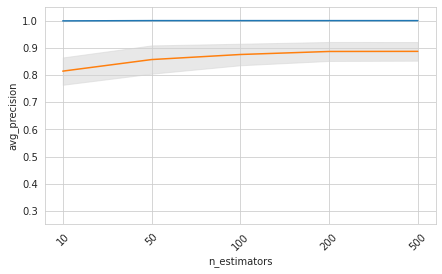

In [11]:
name = 'n_estimators'
value_range = [10,50,100,200,500]

## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)

matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name,ylim = [0.25,1.05], ylabel= 'avg_precision')

#### Noten que, el train está sobreestimado al máximo y que aumentar el número de estimadores está achicando la brecha de varianza. Es decir, está generalizando mejor.  
* Esa sobreestimación del training hay que pensarla relacionada al seteo por default de los demás hiperparámetros.
* Arboles muy profundos? 
* Hojas de muy pocos elementos? 
* Estamos admintiendo splits muy chiquitos?

.

### Max features

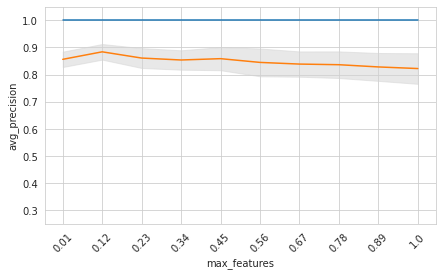

In [12]:
name = 'max_features'
value_range = np.linspace(0.01, 1, 10, endpoint=True)

## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)

matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name,ylim = [0.25,1.05], ylabel= 'avg_precision')

### Min Samnples Split

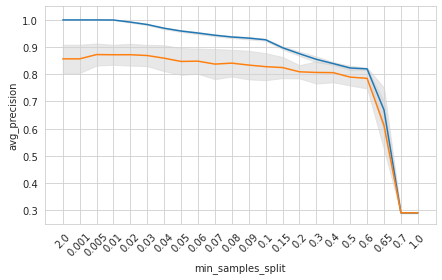

In [13]:
name = 'min_samples_split'
value_range =  np.linspace(0.01, 0.1, 10, endpoint=True)
value_range = [2,0.001,0.005] +[m for m in value_range]+ [0.15,0.2,0.3,0.4,0.5,0.6,0.65,0.7,1.0]

## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)

matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name,ylim = [0.25,1.05], ylabel= 'avg_precision')

## Acá frenemos. 
#### Miremos el gráifco y pensemos/ contrastemos con lo que le pasaba a un árbol individual. 
* No cae abrupto el score en el evaluation set cuando reducimos al mínimo el valor de min_samples split.
* Esto es gracias al bagging. Aunque un arbol en particular sobreajuste por permitirle splitear en hojas de muy pocos elementos, el promedio a lo largo de todos los árboles controla el sobreajuste. En pocas palabras, controla complegidad del modelo. 



* De los parámetros que movimos, es el primero hasta ahora que vemos controlar el sobreajuste en el training. 



## Volvamos a explorar, por ejemplo 
#### Max Features

In [14]:
pipeline.named_steps['clasificador'].set_params(**{'min_samples_split':0.50})
pipeline.named_steps['clasificador']

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.5,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=2718281,
                       verbose=0, warm_start=False)

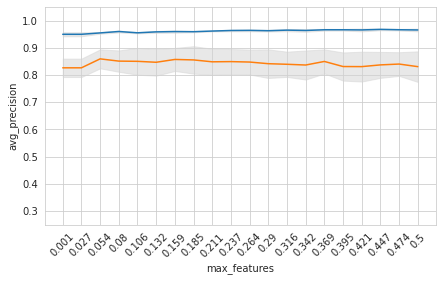

In [15]:
pipeline.named_steps['clasificador'].set_params(**{'min_samples_split':0.05})
name = 'max_features'
value_range = np.linspace(0.001, 0.5, 20, endpoint=True)

## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)

matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name,ylim = [0.25,1.05], ylabel= 'avg_precision')

### Máxima profundiad del arbol admitida (Max Depth)
Otro que controla complegidad. 

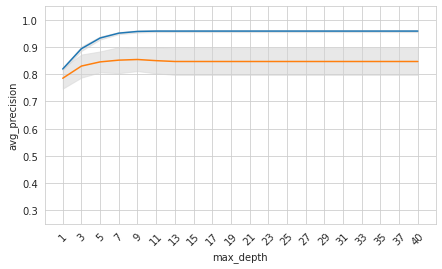

In [16]:
name = 'max_depth'

value_range = np.linspace(1, 40, 20, endpoint=True)
value_range = [int(m) for m in value_range]  # esto no es necesario, sólo está acá por cómo estamos ploteando



## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)

matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name,ylim = [0.25,1.05], ylabel= 'avg_precision')

## minimal Impurity of leafs

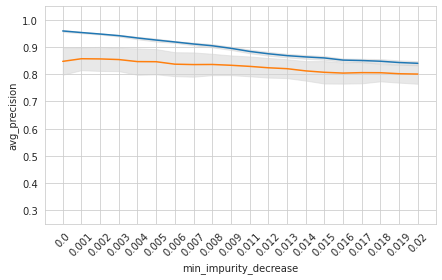

In [17]:
name = 'min_impurity_decrease'

value_range  = np.linspace(0,0.02, 20, endpoint=True)

## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)

matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name,ylim = [0.25,1.05], ylabel= 'avg_precision')

### GridSearch

In [18]:
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',RandomForestClassifier(random_state = SEED, n_estimators=50))]) 

min_samples_splits = np.linspace(0.05, 0.2, 5, endpoint=True)
max_depths = np.linspace(3, 9, 7, endpoint=True)
max_features= np.linspace(0.1, 0.5, 5, endpoint=True)

param_grid = [
  {
      'clasificador__min_samples_split':min_samples_splits,
      'clasificador__max_depth':max_depths,
      'clasificador__max_features':max_features
#      'clasificador__min_impurity_decrease':min_impurity_decrease
  }
 ]
search = GridSearchCV(pipeline, param_grid, 
                      cv=10,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)

In [19]:
print('performance best classif %.4f'%search.best_score_)
print('best hyperparameters: \n')

print(search.best_params_)

aux= cross_val_score(search.best_estimator_, X_train, Y_train, cv=10,scoring = 'average_precision')
print(np.mean(aux),np.std(aux))

print(metrics.average_precision_score(Y_test,search.best_estimator_.predict_proba(X_test)[:,1]))


performance best classif 0.8651
best hyperparameters: 

{'clasificador__max_depth': 8.0, 'clasificador__max_features': 0.1, 'clasificador__min_samples_split': 0.05}
0.865146942583881 0.06594327659857739
0.8101892720748515


In [20]:
metrics.average_precision_score(Y_test,search.best_estimator_.predict_proba(X_test)[:,1])


0.8101892720748515

In [21]:
rfcv = cross_val_score(search.best_estimator_, X_train, Y_train, cv=10,scoring = 'average_precision')
print(np.mean(rfcv),np.std(rfcv))

0.865146942583881 0.06594327659857739


In [22]:
rfcv = cross_val_score(pipeline, X_train, Y_train, cv=10,scoring = 'average_precision')
print(np.mean(rfcv),np.std(rfcv))

0.8727107427460714 0.06103947057050368


In [23]:
pipe2 = search.best_estimator_
pipe2.named_steps['clasificador'].set_params(**{'n_estimators':500})
rfcv = cross_val_score(pipe2, X_train, Y_train, cv=10,scoring = 'average_precision')
print(np.mean(rfcv),np.std(rfcv))

0.869516152177044 0.06967720972697806


In [24]:
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',RandomForestClassifier(random_state = SEED,n_estimators = 2000))])  

rfcv = cross_val_score(pipeline, X_train, Y_train,  cv=10,scoring = 'average_precision')
print(np.mean(rfcv),np.std(rfcv))

0.8879298973403197 0.0631654559964404


In [25]:
pipeline = pipeline.fit(X_train,Y_train)

In [26]:
metrics.average_precision_score(Y_test,pipeline.predict_proba(X_test)[:,1])

0.841860914040701

## Les dejo este post con algo de info de F.I en RF más allá del default basado en Out of Bag

__[Acá, algo de Feature Importance en RF](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)__

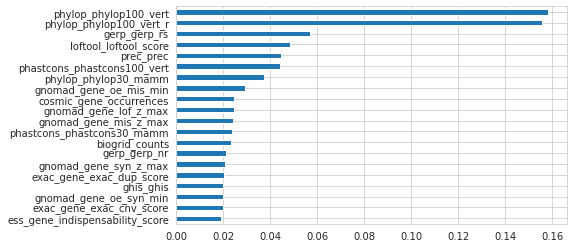

In [27]:
numerical_names = pipeline.named_steps['preprocessing'].transformers[0][2]
categorical_output_names = pipeline.named_steps['preprocessing'].named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()

cols = numerical_names + categorical_output_names

fig, ax = plt.subplots(1)
matplotlib.rcParams['figure.figsize'] = [10, 8]
clf = pipeline.named_steps['clasificador']
fi = pd.Series(clf.feature_importances_,index = cols )
s = fi.sort_values(ascending =False)[0:20]
s.sort_values(ascending =True).plot.barh()



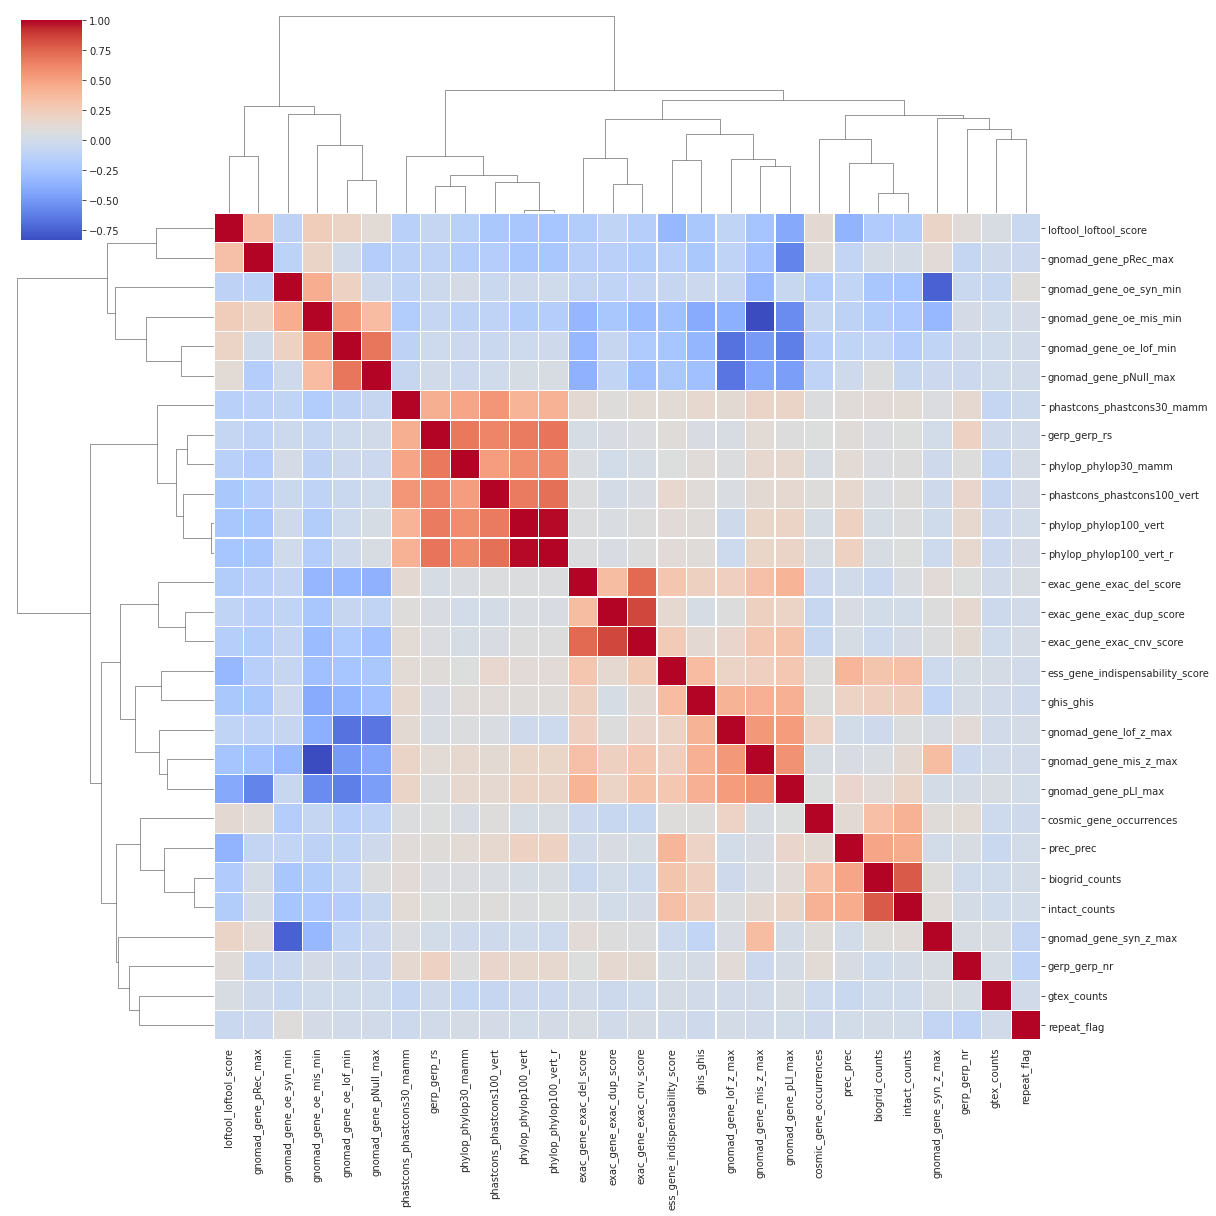

In [28]:
corr = X_train.corr()

cg = sns.clustermap(corr.fillna(0), cmap ='coolwarm', linewidths = 0.2,
                    method = 'complete', xticklabels=1,figsize = (17,17)) 
cg

In [29]:
from sklearn.cluster import AgglomerativeClustering

corr_thr = 0.4
ccols = corr.columns
cluster = AgglomerativeClustering(n_clusters=None, affinity='precomputed',
                                  linkage='complete',distance_threshold=1-corr_thr)
etiquetas = cluster.fit_predict(1-abs(corr))
cldf = pd.DataFrame({'feature':corr.columns,'clusterID':etiquetas})
res = dict(zip(corr.columns, etiquetas)) 

feat =[]
for e in np.unique(etiquetas):
    i = etiquetas == e
    f = ccols[i]
    feat.append(list(f))
feat

[['ghis_ghis', 'gnomad_gene_oe_mis_min', 'gnomad_gene_mis_z_max'],
 ['gnomad_gene_pLI_max', 'gnomad_gene_pRec_max'],
 ['gerp_gerp_rs',
  'phastcons_phastcons100_vert',
  'phastcons_phastcons30_mamm',
  'phylop_phylop100_vert',
  'phylop_phylop100_vert_r',
  'phylop_phylop30_mamm'],
 ['gnomad_gene_oe_syn_min', 'gnomad_gene_syn_z_max'],
 ['gnomad_gene_oe_lof_min', 'gnomad_gene_lof_z_max', 'gnomad_gene_pNull_max'],
 ['loftool_loftool_score'],
 ['prec_prec', 'biogrid_counts', 'intact_counts'],
 ['repeat_flag'],
 ['exac_gene_exac_dup_score', 'exac_gene_exac_cnv_score'],
 ['gerp_gerp_nr'],
 ['cosmic_gene_occurrences'],
 ['gtex_counts'],
 ['ess_gene_indispensability_score'],
 ['exac_gene_exac_del_score']]

In [30]:
cldf.sort_values(by='clusterID').head(15)

,feature,clusterID
20,gnomad_gene_oe_mis_min,0
23,gnomad_gene_mis_z_max,0
11,ghis_ghis,0
25,gnomad_gene_pLI_max,1
26,gnomad_gene_pRec_max,1
1,gerp_gerp_rs,2
2,phastcons_phastcons100_vert,2
3,phastcons_phastcons30_mamm,2
4,phylop_phylop100_vert,2
5,phylop_phylop100_vert_r,2


In [31]:
from rfpimp import permutation_importances, importances, plot_importances

def avPrec(model, X, y,sample_weight=None):
    return metrics.average_precision_score(y_true = y, y_score = model.predict(X),sample_weight =sample_weight)


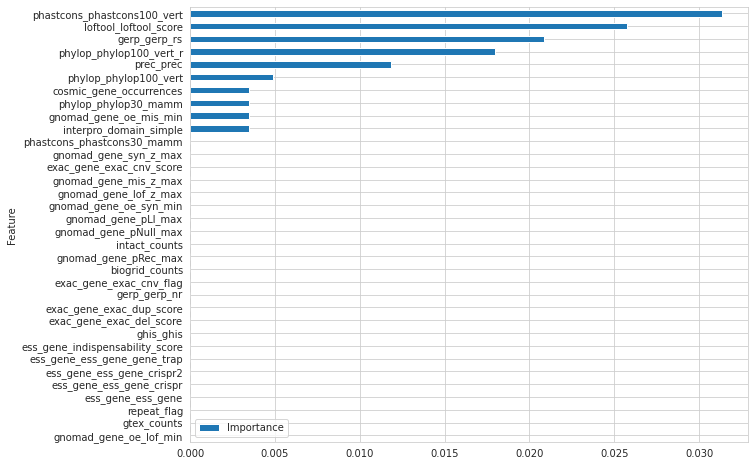

In [32]:
I0 =   importances(pipeline, X_train, y_train, metric = avPrec)
#plot_importances(I0,width=25)
I0.sort_values(by='Importance',ascending=True).plot.barh()

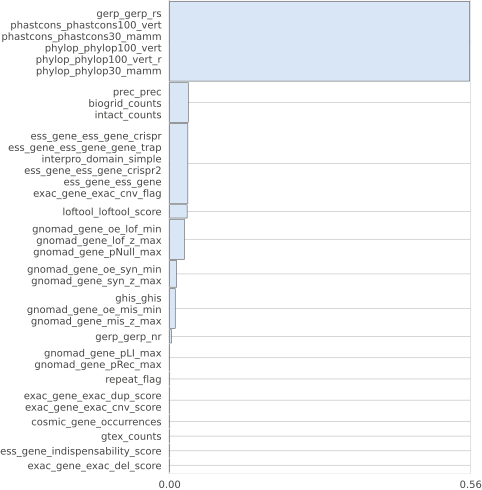

In [33]:
Iclust = importances(pipeline, X_train, y_train, metric= avPrec,features=feat,n_samples=-1)
plot_importances(Iclust,width=7)

### Podemos verlo en en test set

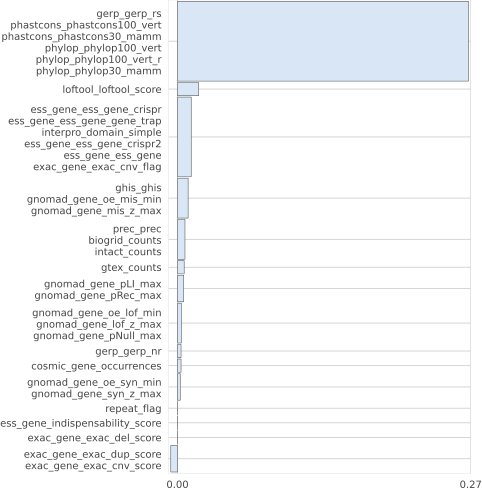

In [34]:
Iclust = importances(pipeline, X_test, y_test, metric= avPrec,features=feat,n_samples=-1)
plot_importances(Iclust,width=7)

## Esto es de los tipos de rfpimp:

(como lectura complementaria, y a absorber con espíritu crítico)

__[Explained AI (de los creadores de rfpimp)](https://explained.ai/rf-importance/index.html#5)__


.

## Shapely

In [35]:
import shap
#import lime ### hay que verlo (e instalarlo)

In [36]:
pp = pipeline.named_steps['preprocessing']
model = pipeline.named_steps['clasificador']

In [37]:
Xprep = pp.transform(X_train)
Xprep = pd.DataFrame(Xprep)  # preproceso para que SHAP pueda perturbar sin nulls

# recupero nombre de columnas
numerical_names = pp.transformers_[0][2]
categorical_output_names = pp.named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()
cols = numerical_names + categorical_output_names
Xprep.columns = cols

Xtrain_sampled = shap.sample(Xprep,200)

In [38]:
shap_tree_explainer = shap.TreeExplainer(model, Xtrain_sampled,model_output = 'probability')
shap_values = shap_tree_explainer.shap_values(Xtrain_sampled)

100%|===================| 399/400 [01:44<00:00]       

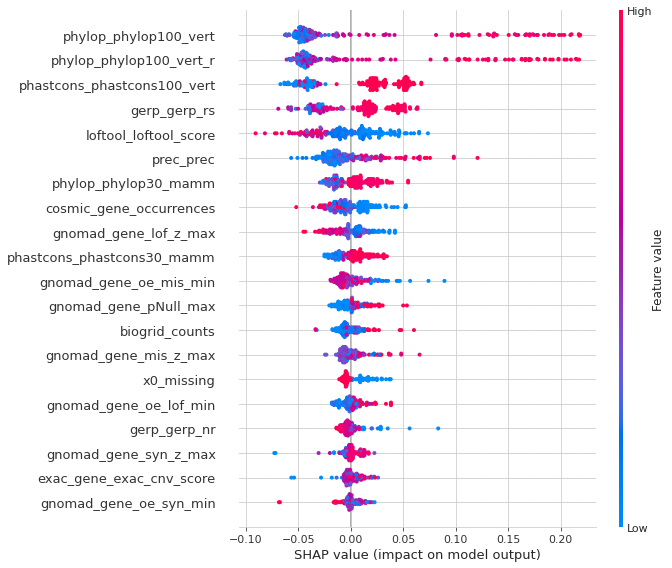

In [39]:
shap.summary_plot(shap_values[1], Xtrain_sampled, plot_type="dot")

### Interaction plots 
* para entender valor predictivo conjunto de grupos de dos variables

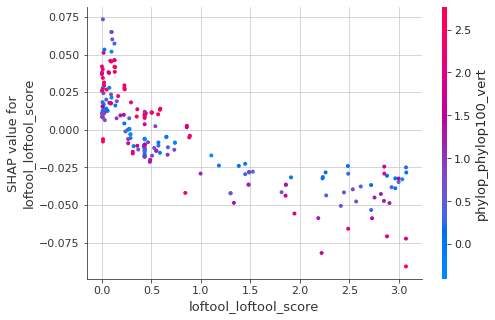

In [40]:
shap.dependence_plot('loftool_loftool_score', shap_values[1], Xtrain_sampled)

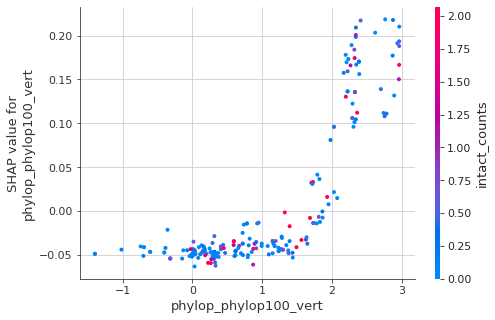

In [41]:
shap.dependence_plot('phylop_phylop100_vert', shap_values[1], Xtrain_sampled)

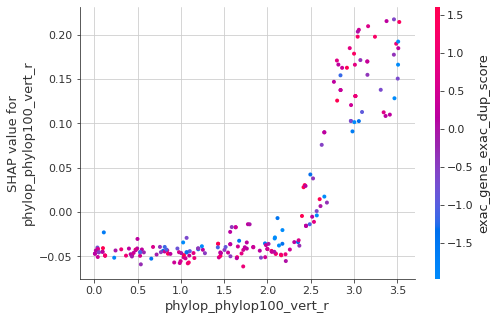

In [42]:
shap.dependence_plot("rank(1)",shap_values[1], Xtrain_sampled)

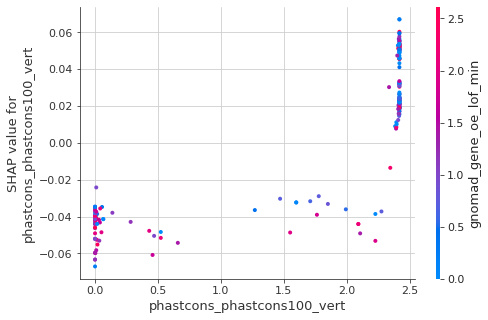

In [43]:
shap.dependence_plot(ind = "rank(2)",shap_values = shap_values[1], 
                     features = Xtrain_sampled,interaction_index = "gnomad_gene_oe_lof_min")

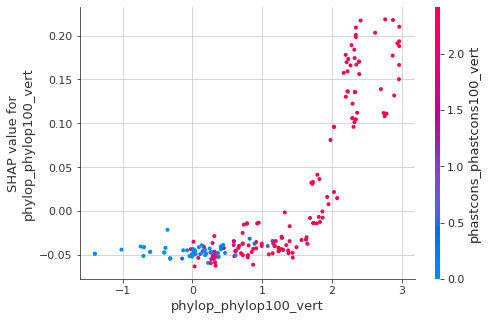

In [44]:
shap.dependence_plot(ind = 'phylop_phylop100_vert',shap_values = shap_values[1], 
                     features = Xtrain_sampled,interaction_index = 'phastcons_phastcons100_vert')

### Explicando predicciones localmente (a nivel de ítem individual) 
Ojo q es costoso en cálculo

In [45]:
shap.initjs()

In [46]:
#Y_train[Xtrain_sampled.index].mean()
Xtrain_sampled.mean().loc[['gnomad_gene_syn_z_max','gnomad_gene_oe_syn_min',
                           'biogrid_counts','phylop_phylop100_vert'],]


gnomad_gene_syn_z_max    -0.399396
gnomad_gene_oe_syn_min    4.852250
biogrid_counts            0.378041
phylop_phylop100_vert     1.064644
dtype: float64

In [47]:
def localplot(j,tree_explainer=shap_tree_explainer,shapValues=shap_values,X=Xtrain_sampled):
    return shap.force_plot(tree_explainer.expected_value[1], shapValues[1][j],X.iloc[[j]])

In [48]:
j=2
print('original class: %s'%Y_train[Xtrain_sampled.index][j])
shap.initjs()
localplot(j)

original class: 0


### Recordar que SHAP ES ADITIVO:
* expected + sum(contributions) = model output value

In [49]:
# para el segundo ítem (j = 2)
shap_tree_explainer.expected_value[1] + shap_values[1].sum(axis=1)[j]

0.08399499207084293

#### (notar que ese valor, 0.08 coincide con el gráfico)

## Veamos otro ejemplo, una variante patogénica

In [50]:
j=3
print('original class: %s'%Y_train[Xtrain_sampled.index][j])
shap.initjs()
localplot(j)

original class: 1


## Distribución de shap output values

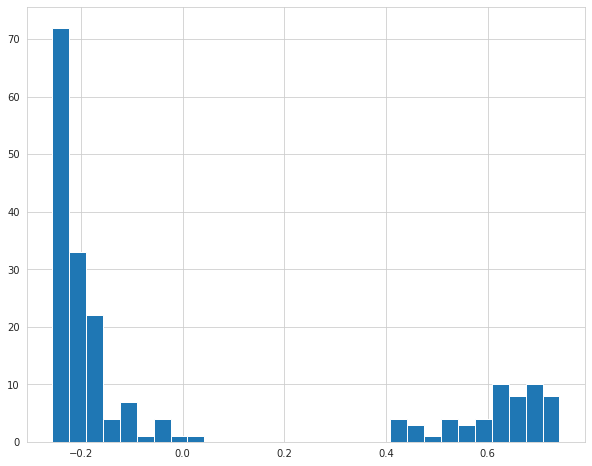

In [51]:
output_values = shap_tree_explainer.expected_value[1] + shap_values[1].sum(axis=1)
classified_as_possitive  = output_values - shap_tree_explainer.expected_value[1]

pd.Series(shap_values[1].sum(axis = 1)).hist(bins = 30)

In [52]:
#shap_tree_explainer = shap.TreeExplainer(model, Xtrain_sampled, feature_perturbation = "tree_path_dependent",model_output = 'raw')
#interaction_values = shap_tree_explainer.shap_interaction_values(Xtrain_sampled)[1]
#shap.decision_plot(shap_tree_explainer.expected_value[1],
#                   interaction_values[1,:,:],feature_names=cols)